In [1]:
# Import libraries and packages
import matplotlib as plt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))
import warnings
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

In [3]:
# initialize the data and labels
print("[INFO] loading images...")
time1 = time.time()   # to measure time taken
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(r'C:\Users\thanawin\Desktop\Deep-learing\90_10_10\detect_split\train')))   # data folder with 3 categorical folders
random.seed(SEED)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, resize the image to be 32x32 pixels (ignoring aspect ratio), 
    # flatten the 32x32x3=3072 pixel image into a list, and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (48, 48)).flatten()
    data.append(image)
 
    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
print("done")

[INFO] loading images...
Time taken: 174.6 seconds
done


In [16]:
# partition the data into 80% training and 20% validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.4, random_state=SEED)

In [17]:
# convert the labels from integers/categories to vectors 
# (for 2-class, binary classification you should use Keras' to_categorical function instead)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)   # fit_transform = find all unique class labels + transform into one-hot encoded labels
testY = lb.transform(testY)         # transform = perform the one-hot encoding (unique class labels already found)

# This is the categorical vector after transformation
# [1, 0, 0] # corresponds to cat
# [0, 1, 0] # corresponds to dog
# [0, 0, 1] # corresponds to panda

In [18]:
trainY

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [19]:
import tensorflow as tf 
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential 
from tensorflow import keras
# define the 3072-1024-512-3 architecture using Keras
model = Sequential()
model.add(Dense(4048, activation = 'relu')) # Relu function is used to avoid Vanishing Gradient problem (when >3 layers are used)
model.add(BatchNormalization(axis = 1)) # Normalizes the data b/w intermediate layers by re-centering and re-scaling 
                                            # And speeds up the training process use higher learning rates making learning easier.
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization(axis = 1))
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization(axis = 1))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization(axis = 1))
model.add(Dense(7, activation = 'sigmoid'))
   
adam = keras.optimizers.Adam(learning_rate = 0.0001) # Adam optimizer is a stochastic gradient descent for training ml/deep learning algo and require fewer parameters for tuning.
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])        # output layer with number of possible class labels

In [20]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.01
EPOCHS = 60
 
# compile the model using SGD as our optimizer and categorical cross-entropy loss
# (you'll want to use binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR)   # Stochastic Gradient Descent (SGD) optimizer
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] training network...


In [21]:
# train the neural network on training data set
# batch_size (32) controls the size of each group of data to pass through the network. 
# Larger GPUs would be able to accommodate larger batch sizes (eg. 64)
time1 = time.time()   # to measure time taken
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken

Epoch 1/60
384/384 [==============================] - 7s 15ms/step - loss: 1.6813 - accuracy: 0.3819 - val_loss: 1.5932 - val_accuracy: 0.4052
Epoch 2/60
384/384 [==============================] - 5s 13ms/step - loss: 1.3391 - accuracy: 0.5091 - val_loss: 1.5358 - val_accuracy: 0.4281
Epoch 3/60
384/384 [==============================] - 5s 14ms/step - loss: 1.1790 - accuracy: 0.5679 - val_loss: 1.4987 - val_accuracy: 0.4543
Epoch 4/60
384/384 [==============================] - 5s 13ms/step - loss: 1.0803 - accuracy: 0.6100 - val_loss: 1.4692 - val_accuracy: 0.4649
Epoch 5/60
384/384 [==============================] - 5s 13ms/step - loss: 1.0219 - accuracy: 0.6273 - val_loss: 1.5598 - val_accuracy: 0.4364
Epoch 6/60
384/384 [==============================] - 5s 13ms/step - loss: 0.9554 - accuracy: 0.6588 - val_loss: 1.6083 - val_accuracy: 0.4387
Epoch 7/60
384/384 [==============================] - 5s 13ms/step - loss: 0.9177 - accuracy: 0.6645 - val_loss: 1.9430 - val_accuracy: 0.3674

Epoch 58/60
384/384 [==============================] - 5s 14ms/step - loss: 0.4733 - accuracy: 0.8302 - val_loss: 2.4555 - val_accuracy: 0.3863
Epoch 59/60
384/384 [==============================] - 5s 13ms/step - loss: 0.4177 - accuracy: 0.8557 - val_loss: 1.8371 - val_accuracy: 0.5097
Epoch 60/60
384/384 [==============================] - 5s 14ms/step - loss: 0.4012 - accuracy: 0.8575 - val_loss: 1.8606 - val_accuracy: 0.4948
Time taken: 313.3 seconds


In [22]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       anger       0.38      0.66      0.48      1578
     disgust       0.75      0.42      0.54      1006
        fear       0.38      0.33      0.35       912
    hapiness       0.85      0.44      0.58      1260
     neutral       0.43      0.58      0.50       966
         sad       0.39      0.41      0.40      1095
    surprise       0.71      0.53      0.61      1364

    accuracy                           0.49      8181
   macro avg       0.56      0.48      0.49      8181
weighted avg       0.56      0.49      0.50      8181



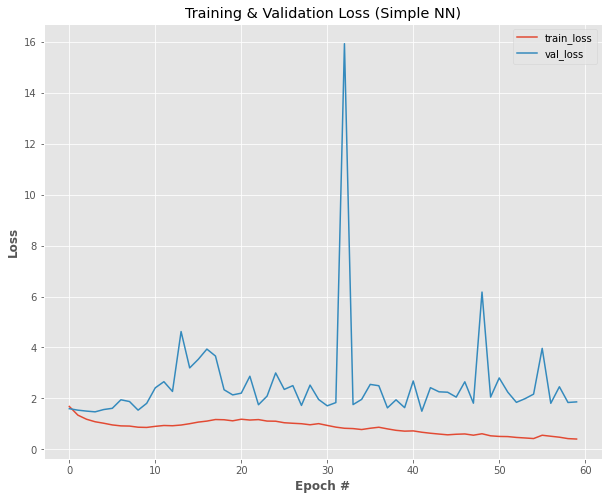

In [23]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss (Simple NN)")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

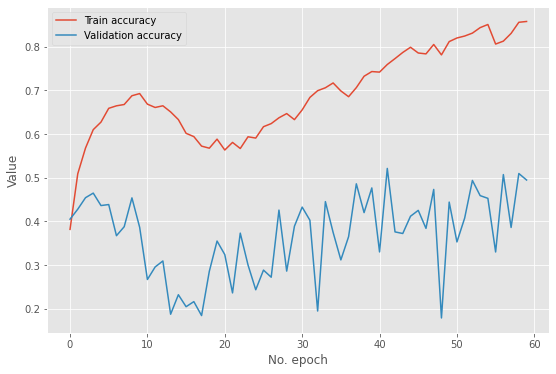

In [24]:
# plot the training and validation accuracy
plt.figure(figsize=(9,6))
plt.plot(H.history['accuracy'], label='Train accuracy')
plt.plot(H.history['val_accuracy'], label='Validation accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4048)              27983824  
_________________________________________________________________
batch_normalization_4 (Batch (None, 4048)              16192     
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              4146176   
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

In [26]:
# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save('simple_NN_model.h5')
f = open('simple_NN_label_bin', "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...


In [27]:
trainX.shape

(12270, 6912)